This is where you decide how to separate various raft shapes. The parameters which are rtweakable are the dstancesc at which two particles are considered to be connected. 

In [1]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vreader

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

Some helper functions. The top one decides the shape of the raft given some values we measure below, u.e. the connectedness of the particles. 
The second one takes one particle, the near and far bond lengths, and a list of other particles, and determines for each of the other ones if it is connected to the first. 
The
average particle radius is around 15 pixeles.

In [ ]:
# take largest isodata image region, and return aclassification
def sideify(ptotallengths,gtotallengths,
                num_pconnections, num_gconnections, num_fpconnections, num_fgconnections):
    if num_fpconnections + num_fgconnections < 2:
        return "ucf"
    elif num_pconnections == 1 and num_gconnections ==0:
        return "p"
    elif num_pconnections == 0 and num_gconnections ==1:
        return "g"
    elif num_pconnections == 1 and num_gconnections ==1:
        return "b"
    else:
        return "ucf"
    
def connect(cv, radii, bloblist): # center of blob2, near and far bonding length, list of other blobs
    num_connections = 0
    num_f_connections = 0
    norm_radius = 15
    total_separations = 0
    normalized_dists = []
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vector_d = vector_dist(cv, cv2)
        total_separations += vector_d
        r1,r2 = radii
        if vector_d <= 2*r1 and vector_d > .2*r1: # blob centers closer than near bonding length
            num_connections += 1
        if vector_d <= 2*r2 and vector_d > .2*r1: # blob centers closer than far bonding length
            num_f_connections += 1
        else:
            pass
        if vector_d <= 4*r1: 
            normalized_dists.append(vector_d/(2*norm_radius))
    return ([num_connections, num_f_connections], normalized_dists, total_separations)

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]        


Take a frame, get transparent and opaque particles separately, and count the distances between particles within and across groups (plas-on-plas_dists, etc).

If two plastic disks are within a distance of p_bond, they are connected. If they are within fp_bond ('far p-bond'), then they are not connected, but they are on oppposite sides of the long axis, and they are both in the raft, i.e. it hasn't disintegrated.

Hence, num_p_connections, etc guage who the neighbours are, and so what is the shape, while num_fp_connections, etc verifies that the raft is whole. A 'plastic-touching'-shaped raft has one plastic-plastic connection, and no glass-glass connection, and two plastic-glass connections, for instance, and should have one fp_bodn aand one fg_bond if whole.

Onnce the values at the top of the following block ('p_bond, etc) are finalized, this is the code that gets copied into ;'Video_readr' to run the transition counting on all the videos. 
Conversely, the code here which picks up the 'plastc' and 'glass' blobs is the same as was determined for opaque and transparent blobs' thresholding, in 'shape testing'. 

In [5]:
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    p_bond = 15*1
    g_bond = 15*1
    fp_bond = 15*1.4
    fg_bond = 15*1.5
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        
        phighlight = morphology.binary_opening(thresh_img, disk(8))
        img = np.copy(frame)
        img[phighlight==0] = 0
        pblobs =skimage.feature.blob_doh(img, min_sigma =8, max_sigma = 17, threshold = 0.007, num_sigma= 15, overlap=0.5)
        
        ghighlight = gaussian(
        opening(
             (thresh_img^phighlight)
                           , disk(1)), sigma = 0.65)
        
        img = np.copy(frame)
        img[ghighlight==0] = 0
        gblobs =skimage.feature.blob_doh(img, min_sigma =9, max_sigma = 16, threshold = 0.005, num_sigma= 15, overlap=0.2)
    
        
        blobset.append([pblobs, gblobs])
        ngblobs = len(gblobs)
        npblobs = len(pblobs)         
        blobs = np.vstack((gblobs, pblobs  ))
        num_blobs = len(blobs)
        
        glas_on_glas_dists =[connect((gblobs[i][1], gblobs[i][0]),(g_bond, fg_bond), gblobs[i+1:]) for i in range(ngblobs-1)]
        glas_on_glas_dists = [[sum([gog[0][0] for gog in glas_on_glas_dists]), sum([gog[0][1] for gog in glas_on_glas_dists])], 
                              list(chain(*[gog[1] for gog in glas_on_glas_dists])),
                             sum([gog[2] for gog in glas_on_glas_dists])]
        num_gconnections,num_fgconnections  = glas_on_glas_dists[0]
        gdistances = glas_on_glas_dists[1]
        gtotallengths = glas_on_glas_dists[2]
        
        plas_on_plas_dists = [connect((pblobs[i][1], pblobs[i][0]),(p_bond, fp_bond), pblobs[i+1:]) for i in range(npblobs-1)]
        plas_on_plas_dists = [[sum([pop[0][0] for pop in plas_on_plas_dists]), sum([pop[0][1] for pop in plas_on_plas_dists])], 
                              list(chain(*[pop[1] for pop in plas_on_plas_dists])),
                             sum([pop[2] for pop in plas_on_plas_dists])]
        num_pconnections, num_fpconnections = plas_on_plas_dists[0]
        pdistances = plas_on_plas_dists[1]
        ptotallengths = plas_on_plas_dists[2]
        
        
        
        num_opconnections = sum([num_pconnections, num_gconnections])#,num_mconnections])
        distances = list(chain(pdistances, gdistances))       
        totallengths = sum([ptotallengths, gtotallengths])
        
        #----------------------what we measured to aid classification------------------------- 
        properties = {'num_blobs':num_blobs,
                      'num_pblobs':npblobs,
                      'num_gblobs':ngblobs,
                      'num_opconnections': num_opconnections,
                      'num_pconnections':num_pconnections, 
                      'num_gconnections':num_gconnections, 
                      'num_fpconnections':num_fpconnections,
                      'num_fgconnections':num_fgconnections,
                     'totallengths':totallengths, 
                      'ptotallengths':ptotallengths, 
                      'gtotallengths':gtotallengths, 
                     'distances':distances, 
                      'pdistances':pdistances, 
                      'gdistances':gdistances}
        #print(properties)
        all_props.append(properties)
        
        #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
        test = True # this can be a test to see if the raft is broken, if you change the final classification function, but with the 'sideify' program I have, I don't need one
        if test: 
            #-----------------------------classify pt 1---------------------------------------
            clas = sideify(ptotallengths,gtotallengths,
                num_pconnections,num_gconnections, num_fpconnections, num_fgconnections)
            filtrate_prop.append(properties)
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






This is a list of frames from three videos (for variety of conditions), for which the classifications are known. The text dictionary keys are the raft shape labels, including broken and 'odd_s', which means four particles connected but not in a stable shape, and the numbers are the indices of the appriopriate frames within those videos. 

The trigger frame is a the index of the first frame, for each video. It's listed in Phantom Cine. Indexes here start at 1.

In [6]:
filenames = filename = glob("./tchakamau/De*both/*_[2,4].avi")+glob("./tchakamau/De*both/*_c.avi")#[1,3,4,5]glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 5
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
#needs reflled
phantom_frames = {"p" : list(range(1, 2400, 24)),
                  "g" :list(range(2843, 2915,1)),
                  "b" :list(range(14677, 14817, 1)),
                 "broken" :list(range(24708, 25042, 1) ),
                 "odd_s" :list() }

#---------------------------------------------------
phantom_frames_2 = {"p" : list(range(9960, 10260, 3)),
                  "g" :list(range(22750, 23050, 3)), 
                  "b" :list(range(1, 300, 3)),
                 "broken" :list(range(9327, 9536, 2)),
                 "odd_s" :list(range(23136, 23146, 1))}


phantom_frames_3 = {"p" : list(range(1, 300, 3)),
                  "g" :list(range(10340, 10390, 6)), 
                  "b" :list(range(9267, 9386, 1)),
                 "broken" :list(range(9848,9873, 1)) ,
                 "odd_s" :list(chain(range(8725,8732, 1), range(10401, 10439, 1)))}
#-----------------------------------
phantom_frames_4 = {"p" : list(range(975, 1126, 3)),
                  "g" :[], 
                  "b" :[],
                 "broken" :[],
                 "odd_s" :[]}

phantom_frame_sets = [phantom_frames,phantom_frames_2, phantom_frames_3]
trigger_frames = [1,1,1]


['./tchakamau\\Density_matchedboth\\45693_15Vpp_2.avi', './tchakamau\\Density_matchedboth\\45693_15Vpp_4.avi', './tchakamau\\Density_matchedboth\\45693_15Vpp_8_c.avi']


In [7]:
p_frames = []

g_frames = []

b_frames = []

odd_s_frames = []

broken_frames = []


framesets = [p_frames, g_frames, b_frames,  odd_s_frames, 
             broken_frames]
framesetnames = ["p", "g", "b", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []    
for vidnum in range(len(filenames)):
    framegen = vreader(filenames[vidnum])
    #frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(framegen)
    pvals  = []
    gvals = []
    bvals = []
    oddsvals = []
    brokenvals = []
    frametypevals = [pvals, gvals, bvals, oddsvals, brokenvals]
    
    for framesetind in range(len(framesetnames)):
        typevals = (phantom_frame_sets[vidnum].get(framesetnames[framesetind]))
        frametypevals[framesetind].extend(typevals)
    frameindex = 0
    tf = trigger_frames[vidnum]
    for frame in framegen:
        for framesetind in range(len(framesetnames)):            
            if abs(tf-frameindex) in frametypevals[framesetind]:
                framesets[framesetind].append((frame[:,:,2], abs(tf-frameindex)))
           
        frameindex += 1
    

<generator object vreader at 0x0000020CC5674048>
<generator object vreader at 0x0000020CC5670C48>
<generator object vreader at 0x0000020CBFB1B7C8>


' for i in range(len(framesetnames)):\n        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])\n        \n        frames = \n        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])\n        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])\n'

Now apply the classification to the known frames and see the pass rate.  Since for Odd_s it's low, that means most weirdly shaped rafts in this test were assigned a shape anyways, probably the correct one, if later odd_s shows humps corresponding to humps of the other classifications on the properties we'll look at. But otherwise, there are good pass rates.

In [8]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)): # for every shape
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[1])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(framesets[i]) # number of frames with this knonw classification
    fil = len(x[0]) # number of frames that passed the first test (which here is forced 'True', but can filter broken frames)
    pas = len(x[1]) # number of frames of this type classified correctly 
    print(orig, fil, pas)
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", pas*100/orig)
        p_rats.append(pas*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

302 302 288
p _vid
original_vid:  302
filtrate:  302
pass ratio:  95.36423841059603


181 181 147
g _vid
original_vid:  181
filtrate:  181
pass ratio:  81.21546961325967


360 360 300
b _vid
original_vid:  360
filtrate:  360
pass ratio:  83.33333333333333


55 55 14
odd_s _vid
original_vid:  55
filtrate:  55
pass ratio:  25.454545454545453


463 463 457
broken _vid
original_vid:  463
filtrate:  463
pass ratio:  98.70410367170626


5 5 5


The parametes we measured

In [9]:
names = {'num_blobs':[],
                      'num_pblobs':[],
                      'num_gblobs':[],
                      'num_opconnections': [],
                      'num_pconnections':[], 
                      'num_gconnections':[], 
                      'num_fpconnections':[], 
                      'num_fgconnections':[],
                     'totallengths':[], 
                      'ptotallengths':[], 
                      'gtotallengths':[], 
                     'distances':[], 
                      'pdistances':[], 
                      'gdistances':[]}
strings = names.keys()
distances = [string for string in strings if 'distances' in string]
simplenames = strings - distances
print(distances, simplenames)

['distances', 'pdistances', 'gdistances'] {'totallengths', 'num_opconnections', 'num_gconnections', 'num_fpconnections', 'num_fgconnections', 'num_pblobs', 'num_blobs', 'ptotallengths', 'num_pconnections', 'num_gblobs', 'gtotallengths'}


The plots show the distributions/histogram for each of the traits, with the frequencies being the number of frames per category at a given value of te trait. 
E.g the number of connections beterrn plastic particles ('num_pconnections' is 1 for the 'plastic touching' and 'both touching' cases and zero for the 'glass touching' case, which means the classification has worked. If theree are problems in the video or thresholding (missing some particles, reading specks as particles), using the wrong bonding lenghts it will show up here, so use this to tweak// confirm those. Particularly use the bottom two histograms to pick good bond lengths. 
Generally, any criteria which could discriminate among shapes can be plotted here to see if the shapes really have such disparate value for it (do the histograms overlap). 

I chose bond lenght sbased o n the histograms, rerun the whole notebook, and see how the pass rate behaves,. It would be even more efficient if there was a way to display examples of the frames on either end of the distribution, for all the states, to see exactly what kind of raft is passing/failing the classificatiion as it is. 

This notebook, for trials with two of each particle, ignores cross-particle bonds and uses within particle bonds alone. The notebooks for the other cases use mixed particle bonds and whichever is appropriate. The mixed particle distances aren't remliable here, probably becuase the transparent particles are offset from their actulal positiosns. 



totallengths averages: 
p : 65 
g : 57 
b : 45 
odd_s : 66 
broken : 49 
totallengths variances: 
p : 60 
g : 90 
b : 157 
odd_s : 313 
broken : 1169 
num_opconnections averages: 
p : 1 
g : 1 
b : 2 
odd_s : 1 
broken : 1 
num_opconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_gconnections averages: 
p : 0 
g : 1 
b : 1 
odd_s : 1 
broken : 0 
num_gconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_fpconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 1 
broken : 1 
num_fpconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_fgconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 1 
broken : 0 
num_fgconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 2 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_blobs averages: 
p : 4 
g : 4 
b : 4 
odd_s : 4 
broken : 3 
num_blobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 

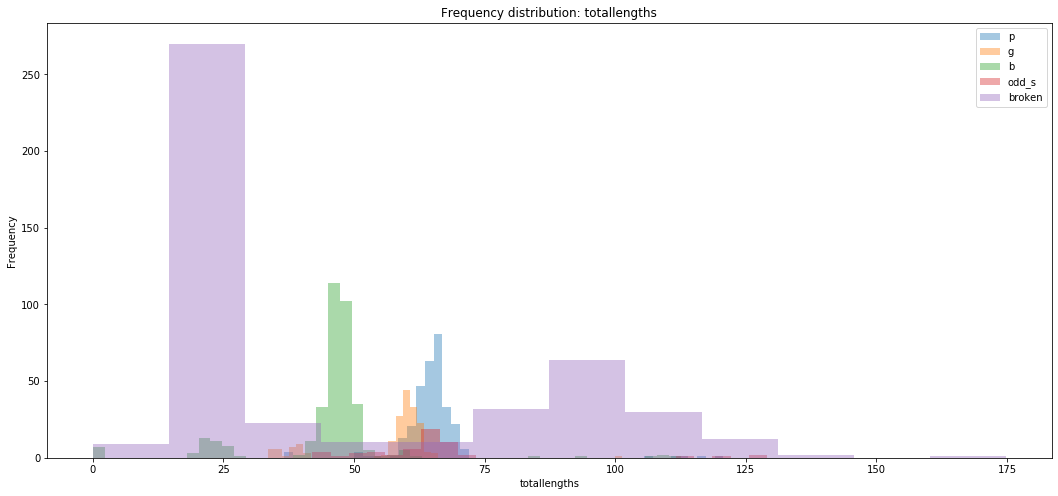

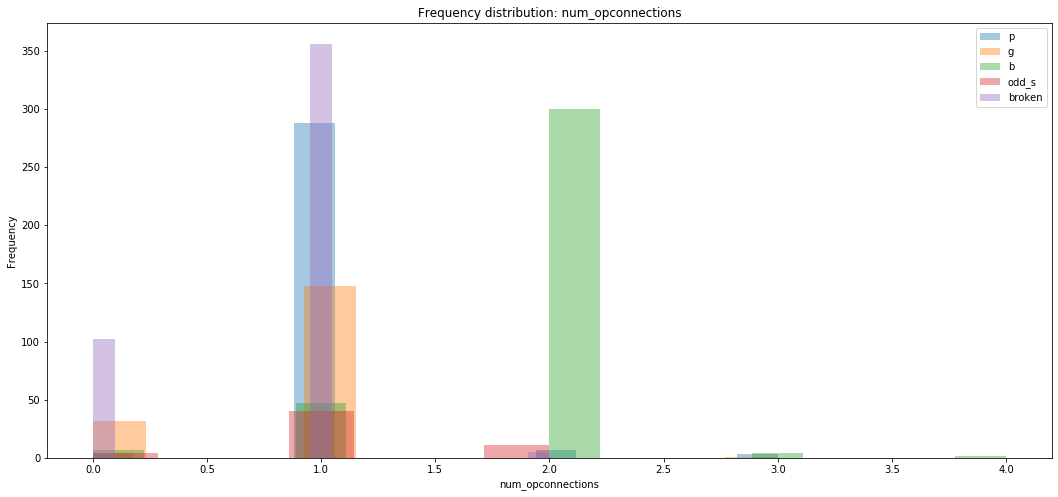

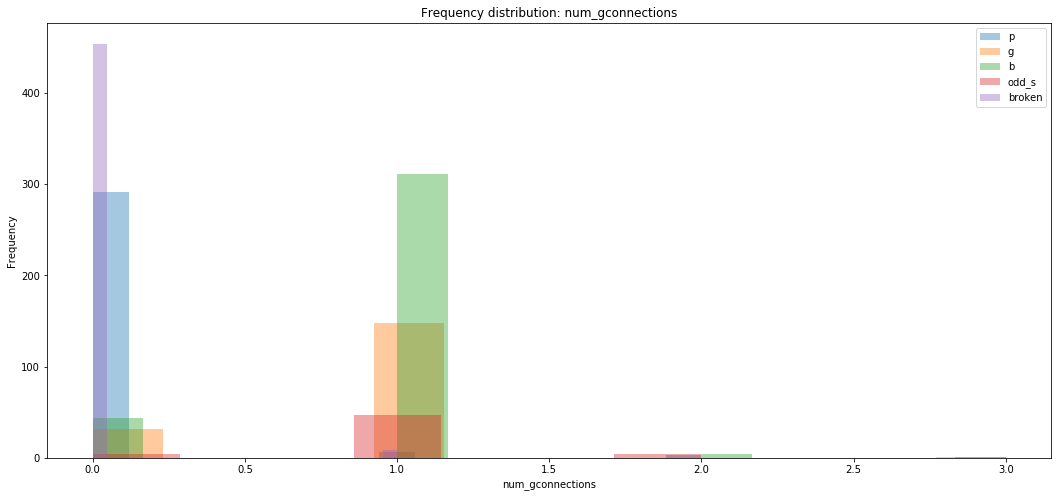

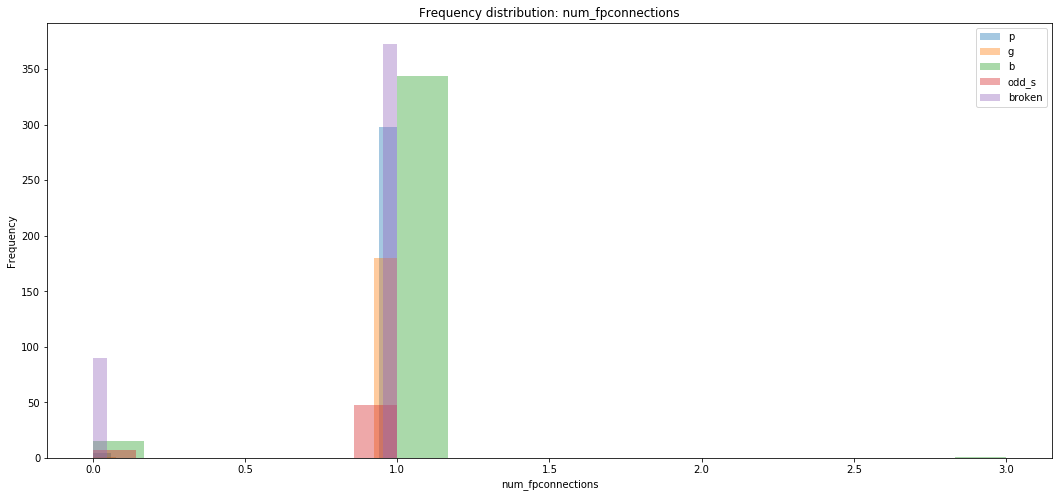

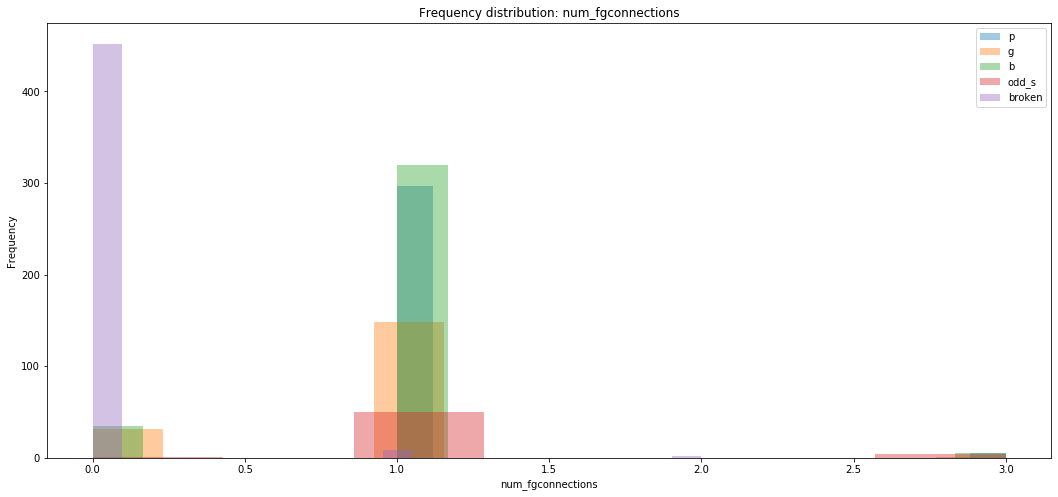

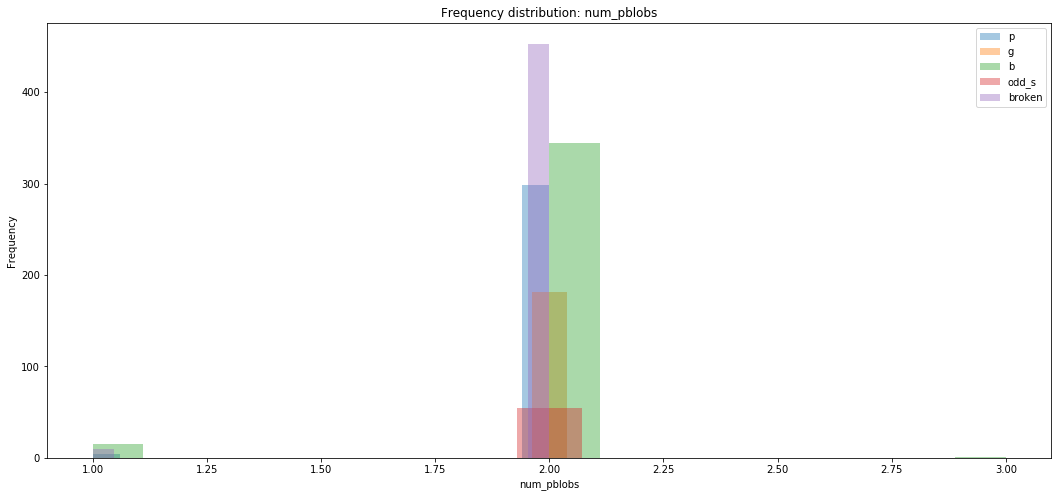

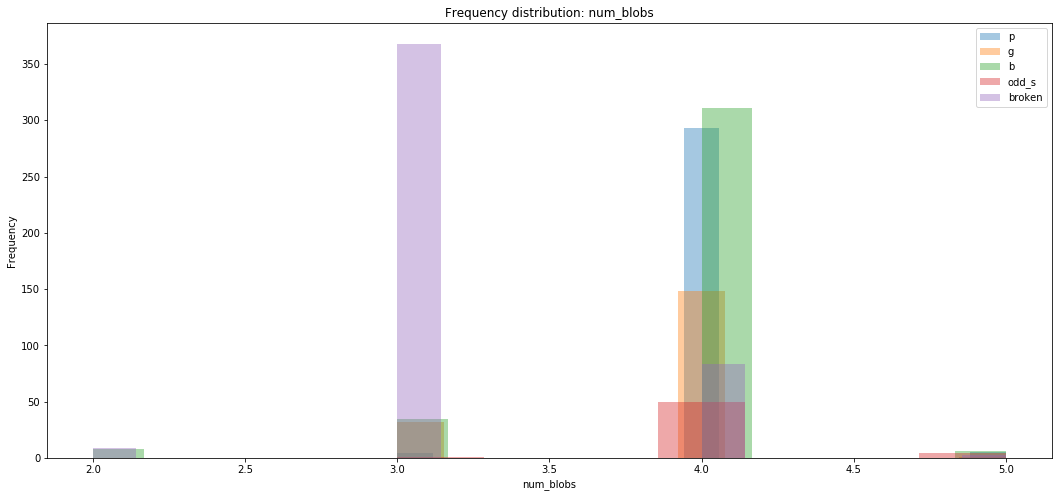

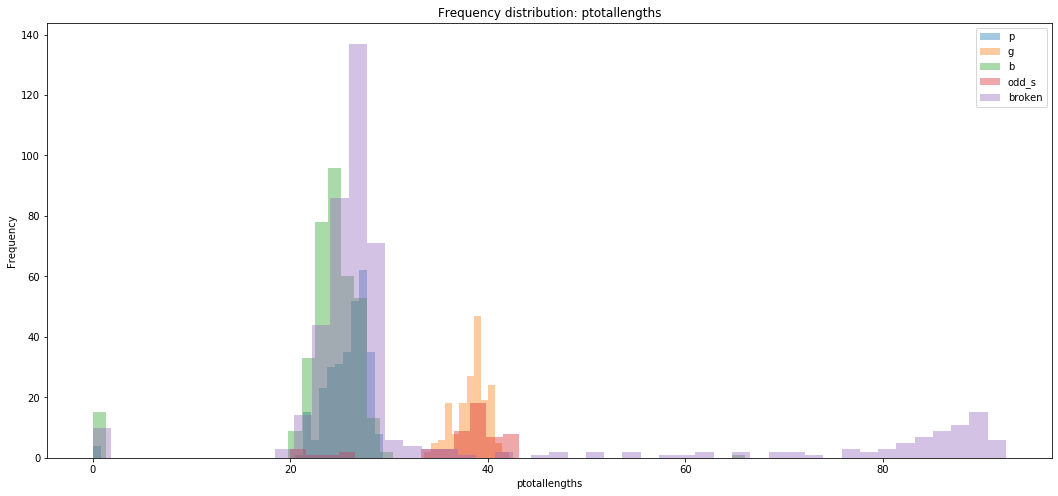

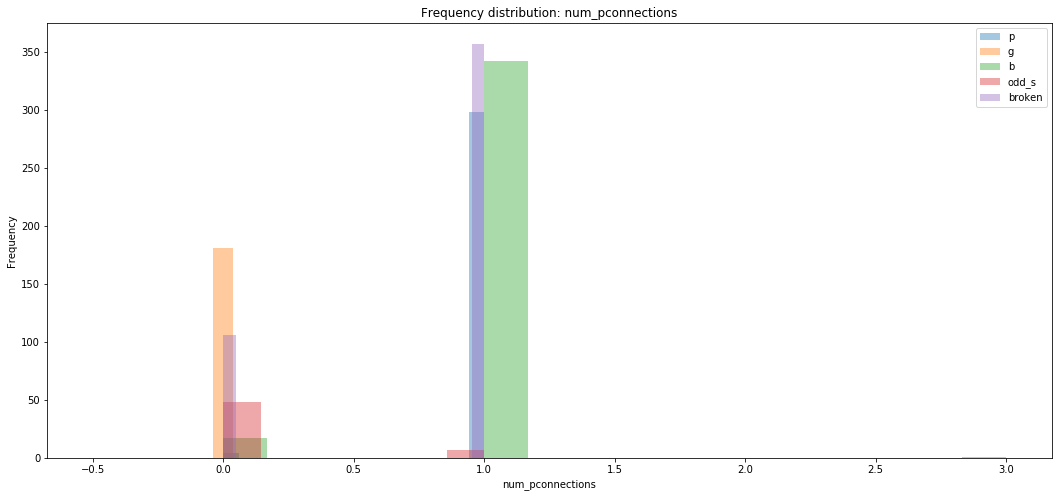

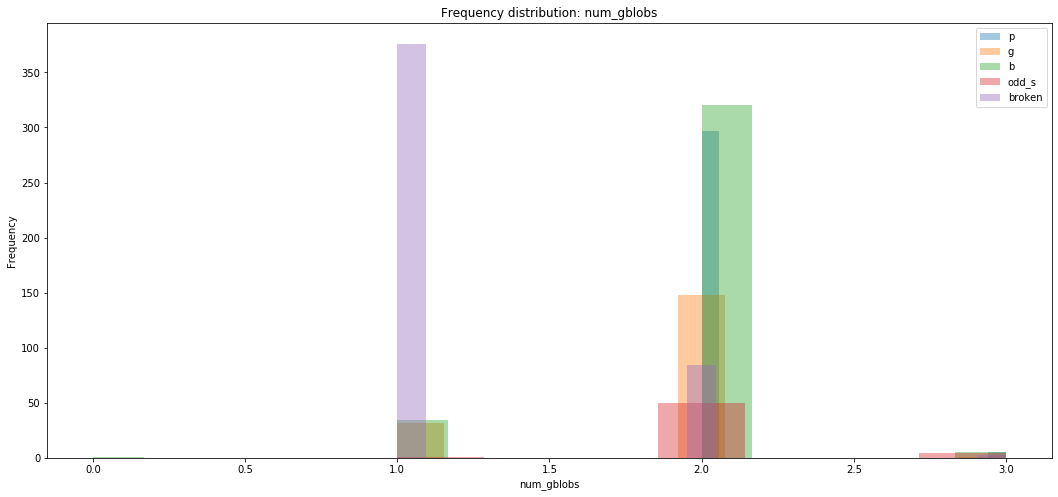

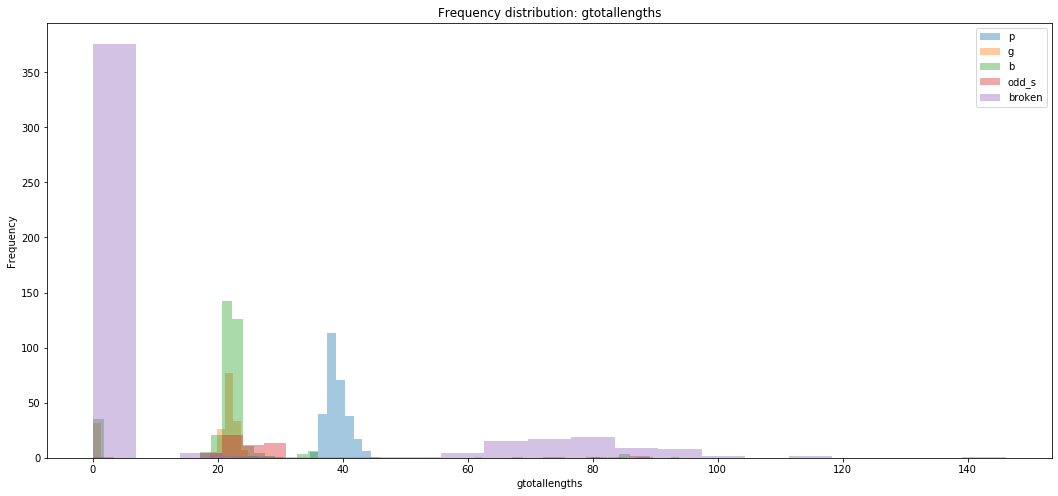

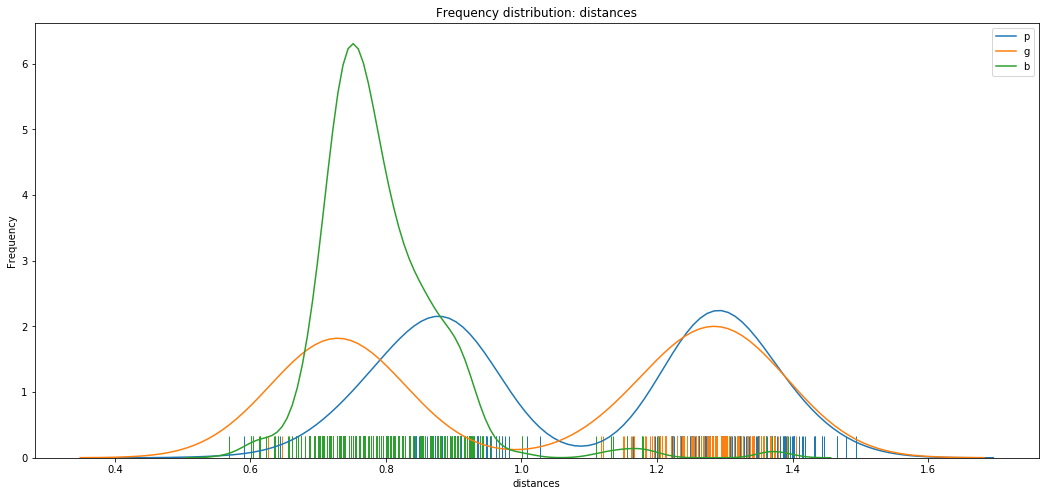

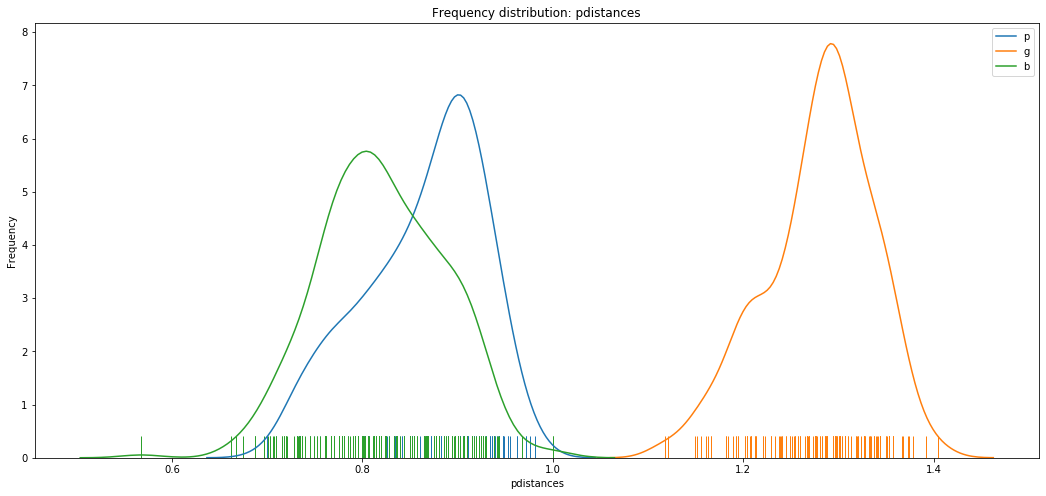

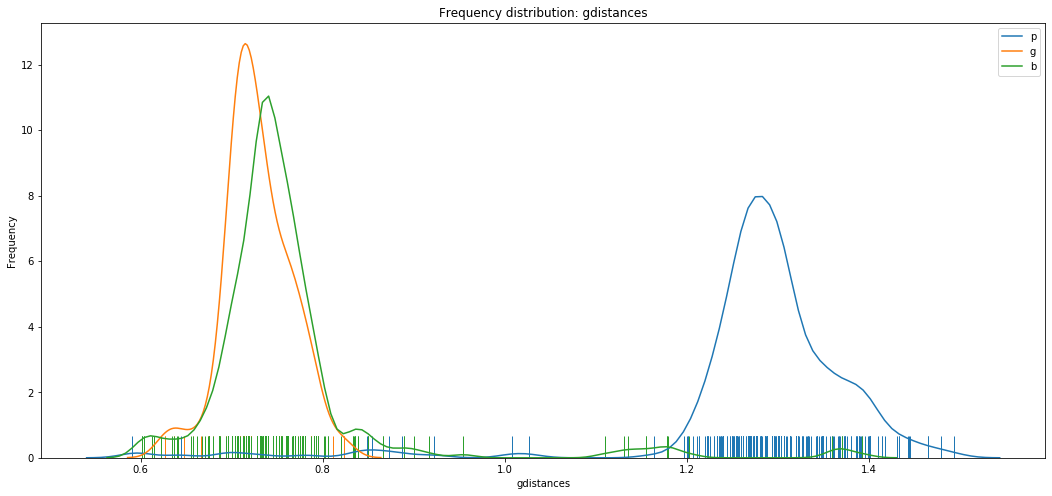

In [10]:
"""Everything"""

# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in a_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-2):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])




In [ ]:
These are the same crurves, but instead of for all the frames, these ar ejust for those fraes which were correctly cassified. 

totallengths averages: 
p : 65 
g : 60 
b : 47 
odd_s : 80 
broken : 48 
totallengths variances: 
p : 7 
g : 3 
b : 5 
odd_s : 774 
broken : 1110 
num_opconnections averages: 
p : 1 
g : 1 
b : 2 
odd_s : 1 
broken : 1 
num_opconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 1 
broken : 0 
num_gconnections averages: 
p : 0 
g : 1 
b : 1 
odd_s : 1 
broken : 0 
num_gconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 1 
broken : 0 
num_fpconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 0 
broken : 1 
num_fpconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_fgconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 2 
broken : 0 
num_fgconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 1 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 2 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_blobs averages: 
p : 4 
g : 4 
b : 4 
odd_s : 4 
broken : 3 
num_blobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
pto

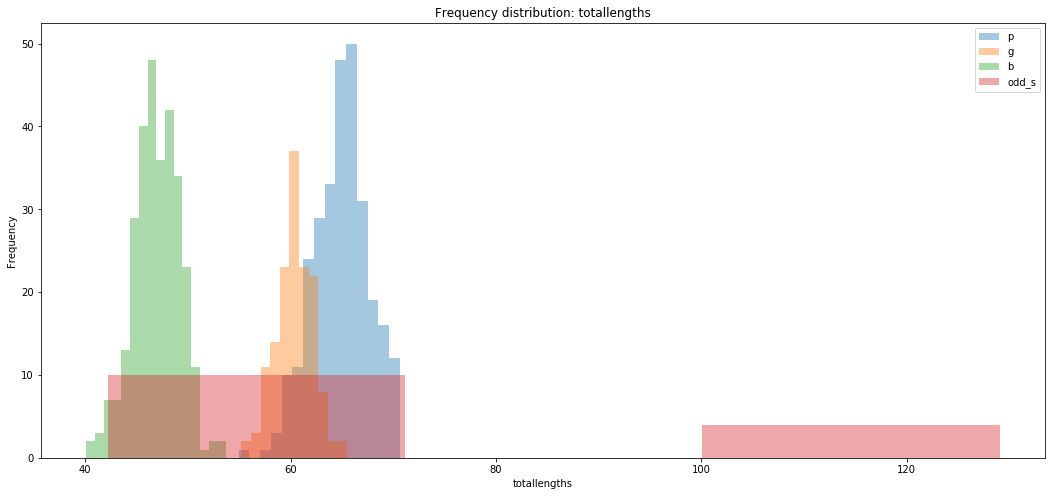

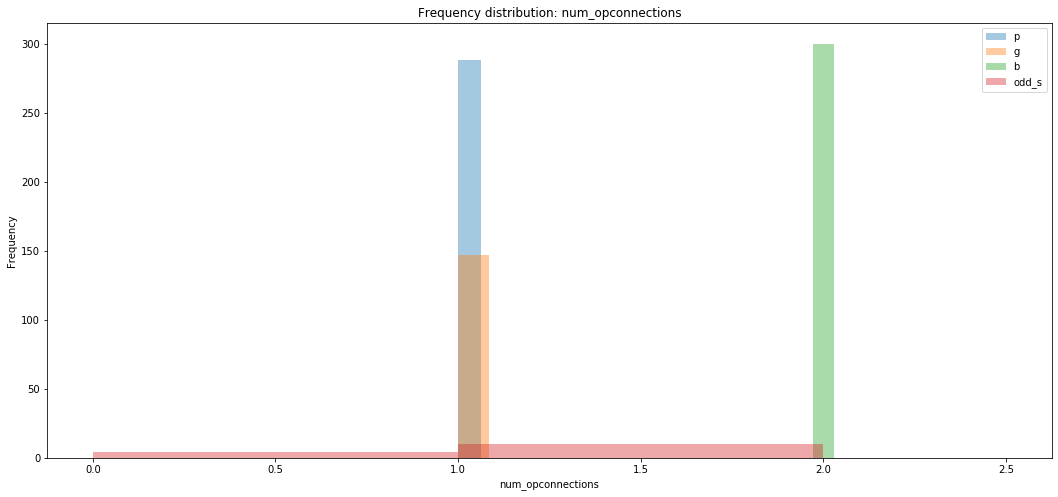

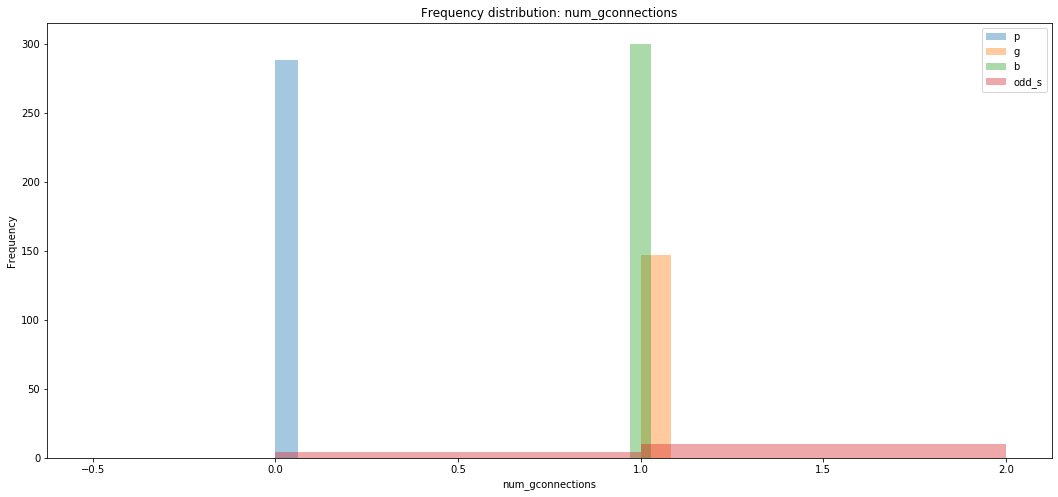

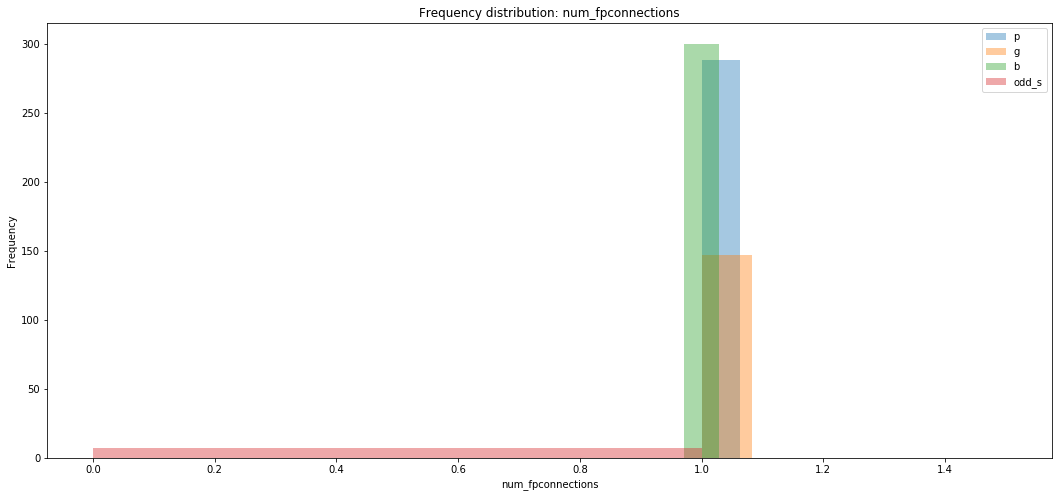

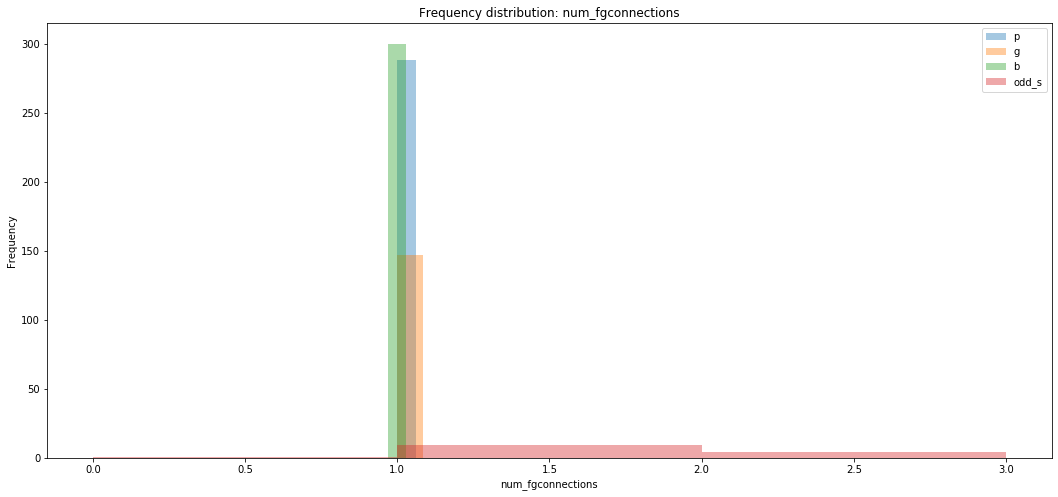

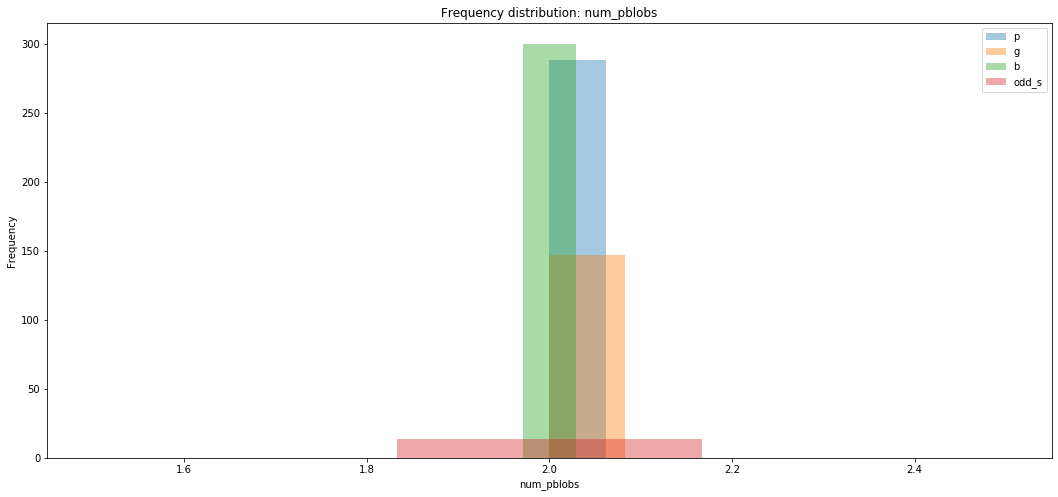

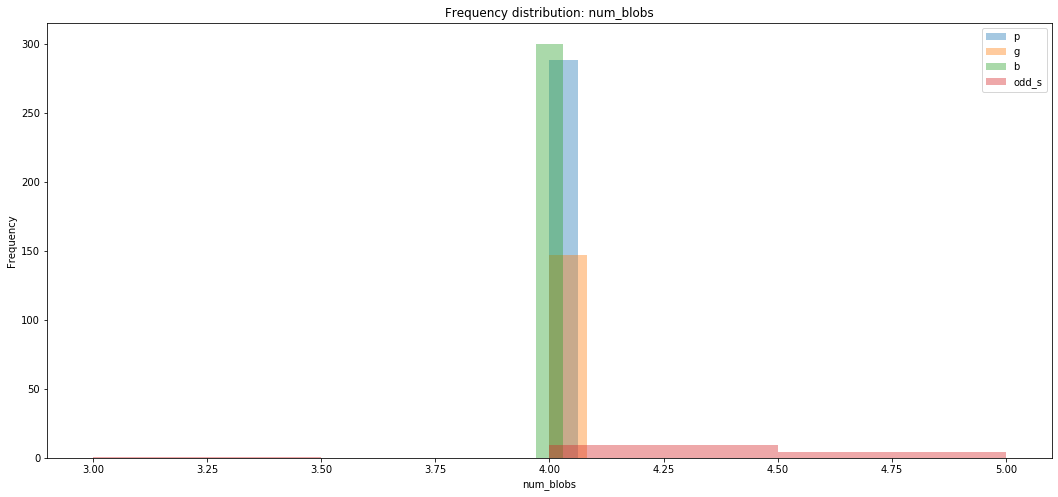

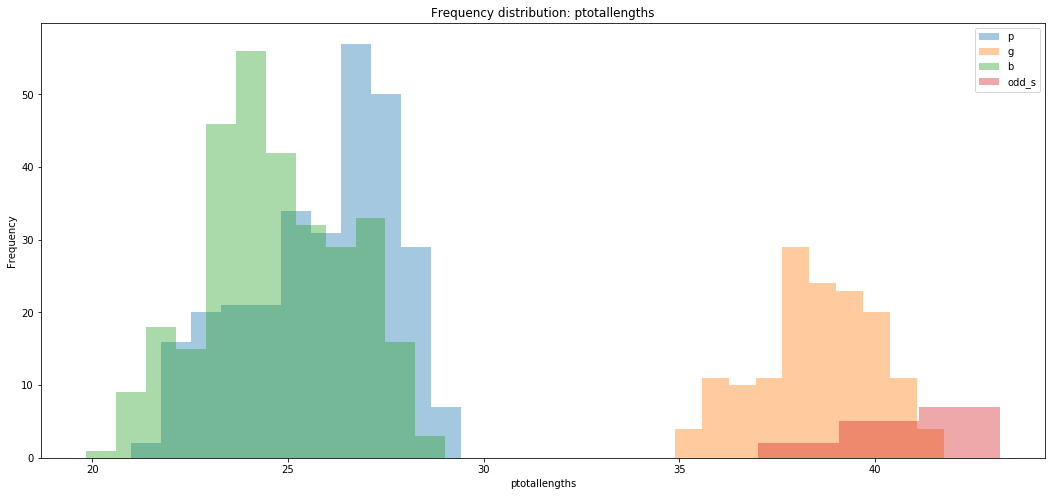

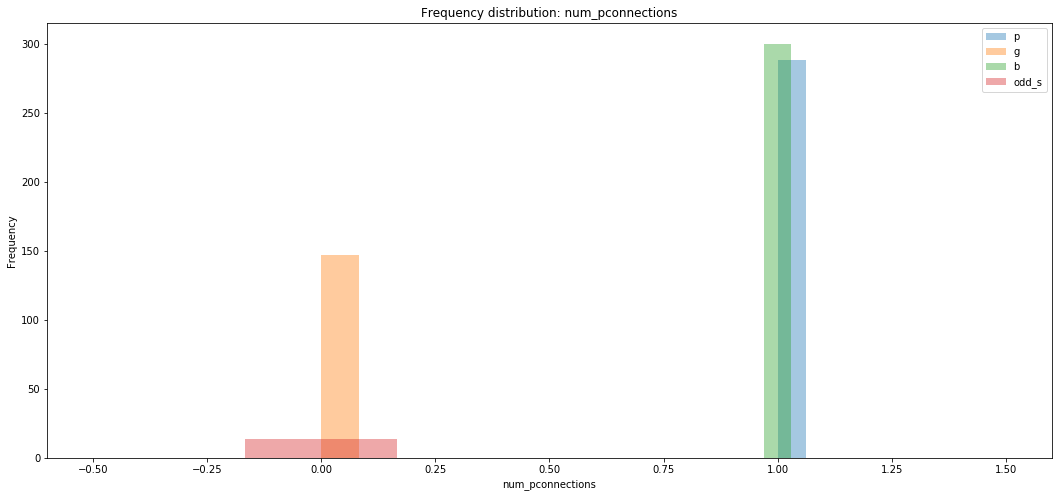

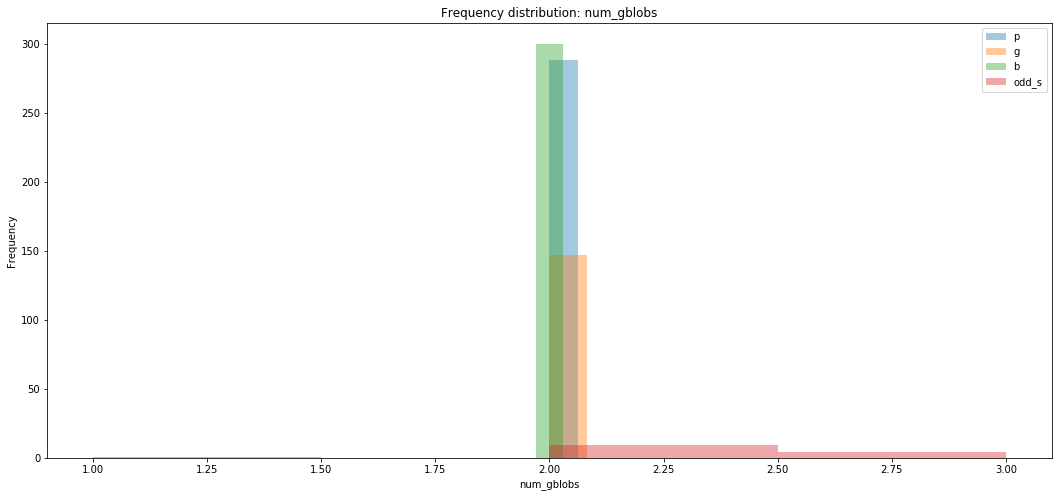

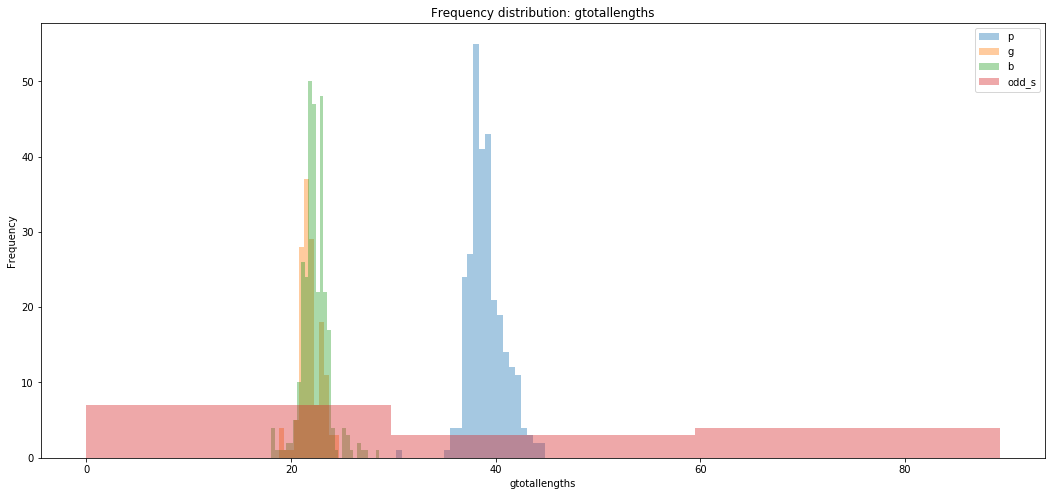

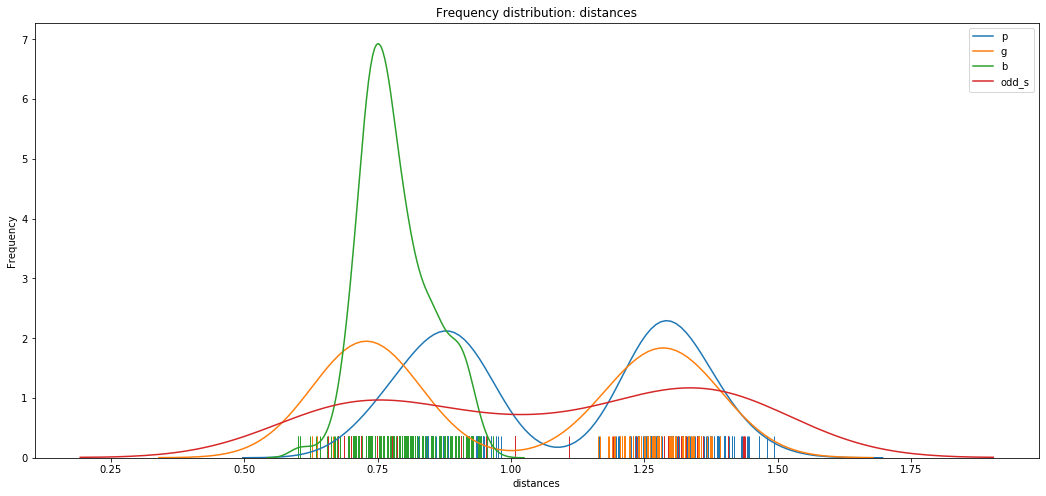

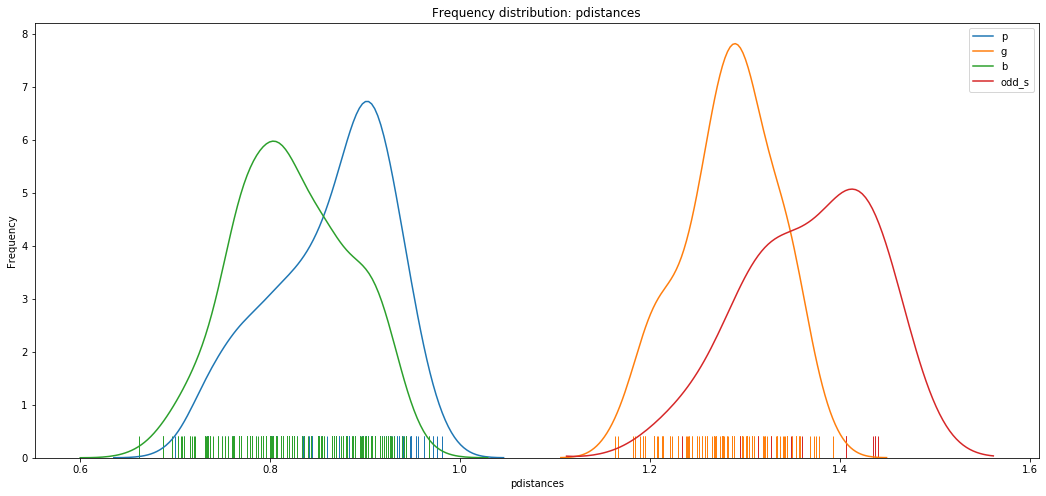

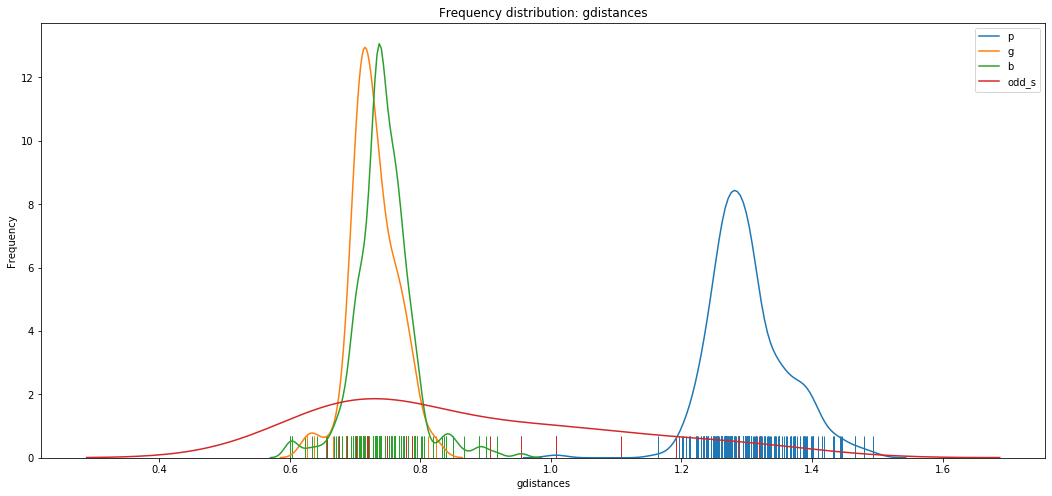

In [12]:

"""Correctly classified"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in passes[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
